# Retail sales forecasting

# About Dataset:
## Context
This dataset contains lot of historical sales data. It was extracted from a Brazilian top retailer and has many SKUs and many stores. The data was transformed to protect the identity of the retailer.

### Content
[TBD]

### Acknowledgements
This data would not be available without the full collaboration from our customers who understand that sharing their core and strategical information has more advantages than possible hazards. They also support our continuos development of innovative ML systems across their value chain.

### Inspiration
Every retail business in the world faces a fundamental question: how much inventory should I carry? In one hand to mush inventory means working capital costs, operational costs and a complex operation. On the other hand lack of inventory leads to lost sales, unhappy customers and a damaged brand.

Current inventory management models have many solutions to place the correct order, but they are all based in a single unknown factor: the demand for the next periods.

This is why short-term forecasting is so important in retail and consumer goods industry.

We encourage you to seek for the best demand forecasting model for the next 2-3 weeks. This valuable insight can help many supply chain practitioners to correctly manage their inventory levels.

# Import packages and set enviroment:

In [108]:
#Import packages

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
#import tensorflow_decision_forests as tfdf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pydot
from IPython.display import Image

plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 3)

# Load data and do some EDA:

In [109]:
# load sales data
raw_sales = pd.read_csv(
    r'C:\Users\andre\Desktop\Scripts\DATASETS\CSV\Retail Sales Forecasting\mock_kaggle.csv'
)

raw_sales.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [110]:
raw_sales.columns = ['DATE', 'SALES', 'STOCKS', 'PRICE']

raw_sales.head()


,DATE,SALES,STOCKS,PRICE
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [111]:
max_date = raw_sales['DATE'].max()
min_date = raw_sales['DATE'].min()

print(min_date, max_date)

2014-01-01 2016-07-31


In [112]:
# Create a new 'ID' column with unique integer values for each unique date
raw_sales['IDs'] = pd.factorize(raw_sales['DATE'])[0]

# Display the first few rows of the raw_sales DataFrame
raw_sales.head()


,DATE,SALES,STOCKS,PRICE,IDs
0,2014-01-01,0,4972,1.29,0
1,2014-01-02,70,4902,1.29,1
2,2014-01-03,59,4843,1.29,2
3,2014-01-04,93,4750,1.29,3
4,2014-01-05,96,4654,1.29,4


In [113]:
raw_sales = raw_sales[raw_sales['SALES'] != 0]

In [114]:
# raw_sales = raw_sales.groupby(raw_sales['DATE'])['SALES'].sum()
# raw_sales.head()

In [115]:
# Split the raw_sales DataFrame into training and testing sets
train, test = train_test_split(raw_sales, test_size=0.2)

# Display the shape of the training and testing sets
print(train.shape)
print(test.shape)

(660, 5)
(165, 5)


In [116]:
# Split the raw_sales DataFrame into two DataFrames with specific shapes
train = raw_sales.iloc[:660]
test = raw_sales.iloc[660:]

In [117]:
# Create a new 'ID' column with unique integer values for each unique date
train['IDs'] = pd.factorize(train['DATE'])[0]
test['IDs'] = pd.factorize(test['DATE'])[0]

C:\Users\andre\AppData\Local\Temp\ipykernel_5436\2549906353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['IDs'] = pd.factorize(train['DATE'])[0]
C:\Users\andre\AppData\Local\Temp\ipykernel_5436\2549906353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['IDs'] = pd.factorize(test['DATE'])[0]


In [118]:
# # Set the ID column as the index in our dataframes:
# raw_sales.set_index('IDs', inplace=True)
# train.set_index('IDs', inplace=True)
# test.set_index('IDs', inplace=True)

In [119]:
print(
    raw_sales.head(),
    train.head(),
    test.head()
)

         DATE  SALES  STOCKS  PRICE  IDs
1  2014-01-02     70    4902   1.29    1
2  2014-01-03     59    4843   1.29    2
3  2014-01-04     93    4750   1.29    3
4  2014-01-05     96    4654   1.29    4
5  2014-01-06    145    4509   1.29    5          DATE  SALES  STOCKS  PRICE  IDs
1  2014-01-02     70    4902   1.29    0
2  2014-01-03     59    4843   1.29    1
3  2014-01-04     93    4750   1.29    2
4  2014-01-05     96    4654   1.29    3
5  2014-01-06    145    4509   1.29    4            DATE  SALES  STOCKS  PRICE  IDs
768  2016-02-14    105    1510   2.19    0
769  2016-02-15     25    1510   2.19    1
770  2016-02-16     47    1909   2.19    2
771  2016-02-17     63    1845   2.19    3
772  2016-02-18     39    1806   2.19    4


<Axes: >

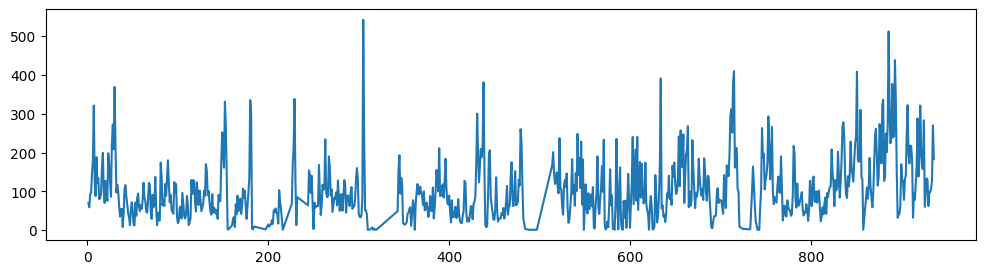

In [120]:
#@title
# plot the sum of all the sales over the last 2 months.
# sales = raw_sales['SALES'].sum().squeeze().astype(float)
sales = raw_sales['SALES'].squeeze().astype(int)
sales.plot.line()


<Axes: >

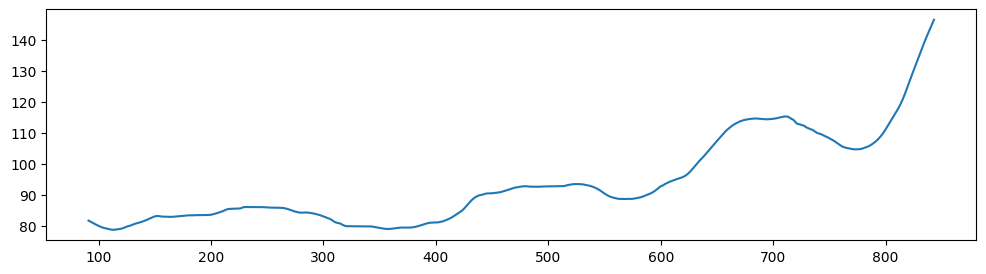

In [121]:
sales.rolling(180, center=True, win_type="triang").mean().plot.line()

<Axes: >

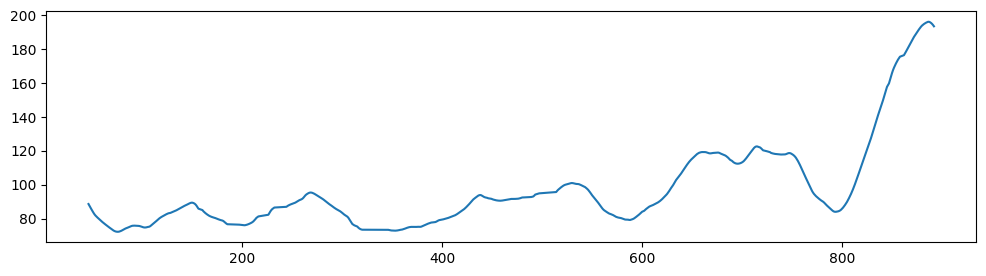

In [122]:
sales.rolling(90, center=True, win_type="triang").mean().plot.line()

<Axes: >

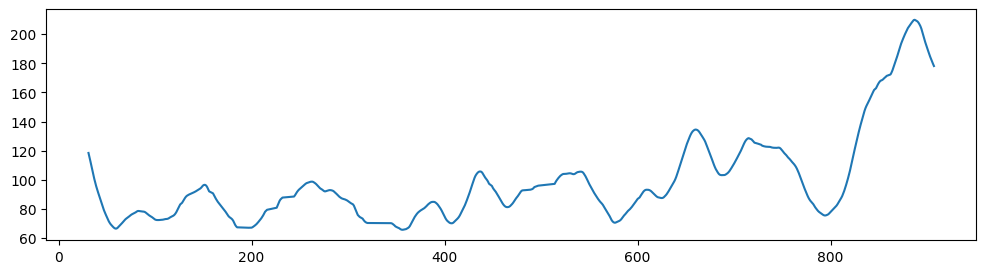

In [123]:
sales.rolling(60, center=True, win_type="triang").mean().plot.line()

<Axes: >

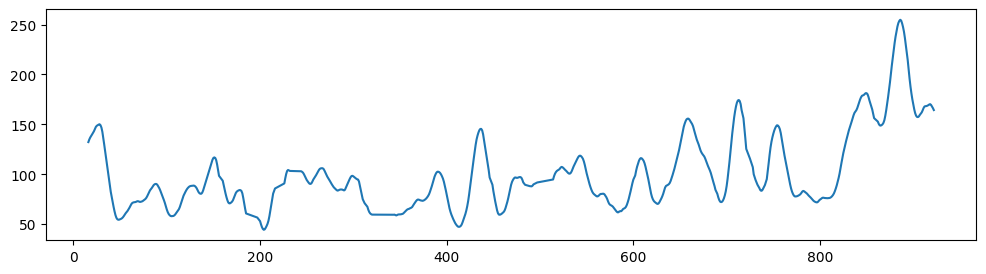

In [124]:
sales.rolling(30, center=True, win_type="triang").mean().plot.line()

<Axes: >

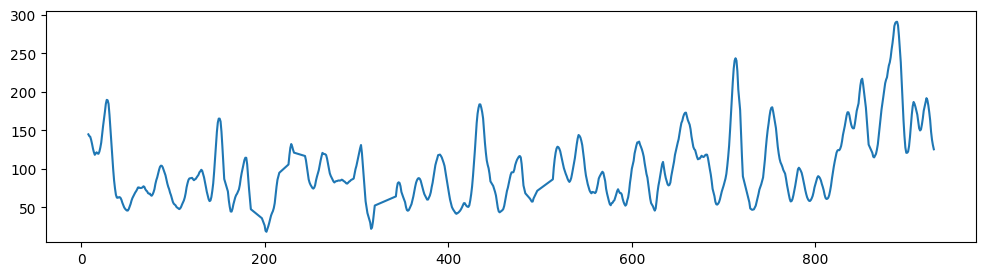

In [125]:
sales.rolling(15, center=True, win_type="triang").mean().plot.line()

<Axes: >

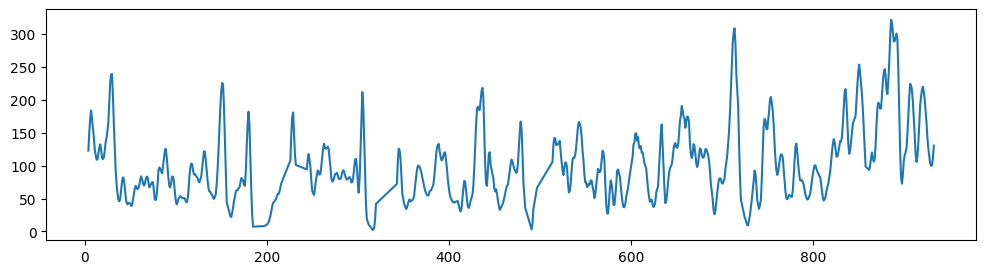

In [126]:
sales.rolling(7, center=True, win_type="triang").mean().plot.line()

<Axes: ylabel='Density'>

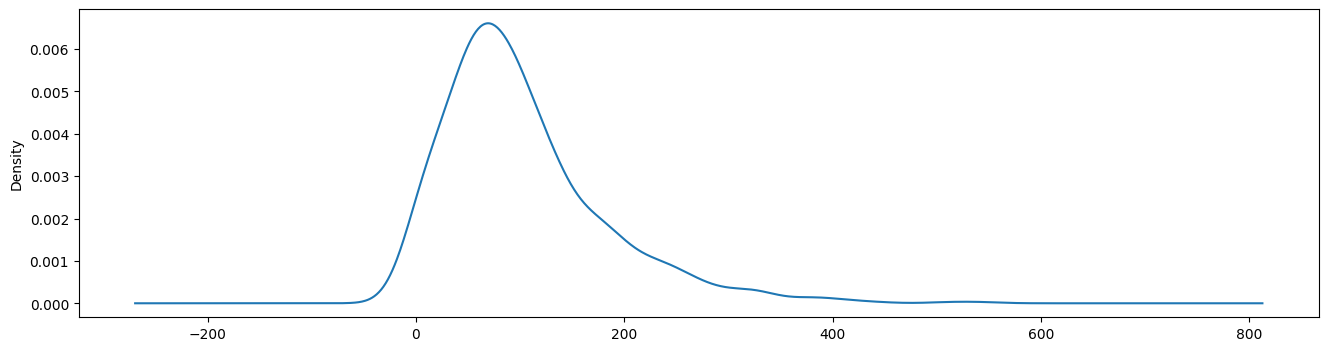

In [127]:
raw_sales['SALES'].plot(kind='kde', figsize= (16,4))

In [128]:
data = raw_sales.copy()

In [129]:
# Convert the 'DATE' column to a datetime object
data['DATE'] = pd.to_datetime(data['DATE'])

# Create a new column 'YEAR_MONTH' that contains the year and month of each date
data['YEAR_MONTH'] = data['DATE'].dt.to_period('M')

# Create a new column 'MONTH' that contains the month of each date
data['MONTH'] = data['DATE'].dt.month

# Group the data by the 'MONTH' column and sum the 'SALES' column
monthly_sales = data.groupby('MONTH')['SALES'].sum().reset_index()

# Group the data by the 'YEAR_MONTH' column and sum the 'SALES' column
year_month_sales = data.groupby('YEAR_MONTH')['SALES'].sum().reset_index()


In [130]:
monthly_sales.head()

,MONTH,SALES
0,1,8815
1,2,6768
2,3,7722
3,4,8141
4,5,7547


In [131]:
year_month_sales.head()

,YEAR_MONTH,SALES
0,2014-01,3985
1,2014-02,2018
2,2014-03,2137
3,2014-04,1990
4,2014-05,2493


Text(0.5, 0.98, '')

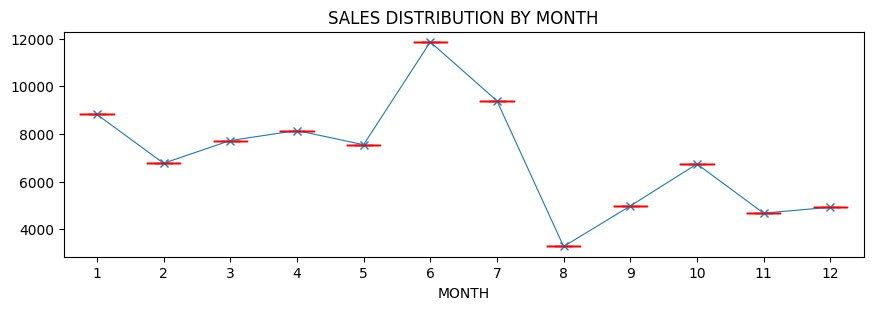

In [132]:
fig, ax = plt.subplots(figsize=(10,3))
# data['MONTH'] = data['DATE'].dt.month.index
monthly_sales.boxplot(column='SALES', by='MONTH', ax=ax, color = 'red')
monthly_sales.groupby('MONTH')['SALES'].median().plot(style='x-', linewidth= 0.8, ax=ax)
ax.set_label('SALES')
ax.set_title('SALES DISTRIBUTION BY MONTH')
fig.suptitle('')

# Time to forecast!

# Findig the right parameters:
One way to find the best values for the order and seasonal_order parameters is to use a grid search. This involves fitting a SARIMA model for different combinations of the parameters and choosing the combination that results in the best model fit.

The p, d, and q parameters in a SARIMA model represent the order of the autoregressive (AR), differencing (I), and moving average (MA) terms, respectively. The values of these parameters determine the complexity of the model.

In the example code I provided, I chose to let p, d, and q take any value between 0 and 2 as a starting point for the grid search. This means that the grid search will consider SARIMA models with AR, I, and MA terms of order 0, 1, or 2. This range of values is often a good starting point for time series forecasting problems.

However, depending on your data and the specific problem you’re trying to solve, you may need to consider a wider range of values for these parameters. You can adjust the range of values for p, d, and q in the grid search to find the best model for our data.

Here’s an example of how you might do this:

In [133]:
# # Define the p, d and q parameters to take any value between 0 and 2
# p = d = q = range(0, 3)

# # Generate all different combinations of p, d and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, d and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# # Make sure the DATE column is in datetime format
# train['DATE'] = pd.to_datetime(train['DATE'])

# # Set the DATE column as the index
# train.set_index('DATE', inplace=True)

# best_aic = np.inf
# best_pdq = None
# best_seasonal_pdq = None

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             model = SARIMAX(train['SALES'], order=param, seasonal_order=param_seasonal)
#             results = model.fit()
            
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_pdq = param
#                 best_seasonal_pdq = param_seasonal
                
#         except:
#             continue

# print(f'Best SARIMA model: {best_pdq} x {best_seasonal_pdq} with AIC={best_aic}')

In [134]:
# We commented the code because we need to run one time for this analisys it took 45-50'.
# The result was:
# Best SARIMA model: (0, 2, 2) x (2, 2, 2, 12) with AIC=14.0

This code will fit a SARIMA model for each combination of order and seasonal_order parameters and choose the combination that results in the lowest AIC value. The AIC (Akaike Information Criterion) is a measure of how well the model fits the data while penalizing models with more parameters to avoid overfitting.

In [135]:
# Now we assign the values we find and run our forecast model:
p, d, q = 0, 2, 2
P, D, Q, s = 2, 2, 2, 12

In [136]:

# Store selected time series ids in a variable
ids_subset = train['IDs'].unique().tolist()

In [137]:
num_horizons= 2

In [138]:
date = (train['DATE'].unique().tolist() * num_horizons)
id = np.repeat(ids_subset, num_horizons)
pred = [None] * len(ids_subset) * num_horizons
print(date[:7], id[:7], pred[:7])


['2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08'] [0 0 1 1 2 2 3] [None, None, None, None, None, None, None]


In [139]:
print(len(date), len(id), len(pred))

1320 1320 1320


In [140]:
df_preds_sarima = pd.DataFrame(
    {
        'ID': np.repeat(ids_subset, num_horizons),
        'DATE': train['DATE'].unique().tolist() * num_horizons,
        'PRED': [None] * len(ids_subset) * num_horizons
    },
).set_index('ID')

df_preds_sarima.head()

,DATE,PRED
ID,,
0,2014-01-02,None
0,2014-01-03,None
1,2014-01-04,None
1,2014-01-05,None
2,2014-01-06,None


In [141]:
# # Current fitting try:

for id in tqdm(ids_subset):
    # select training time series
    train_ts = (
        train[train['IDs'] == id]['SALES'].to_numpy()
    )
    # instance SARIMA model
    model = ARIMA(
        endog=train_ts,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s)
    )
    # fit model
    model = model.fit()

    # predict
    pred = model.forecast(steps=num_horizons)

    # store predictions
    df_preds_sarima.loc[id, 'PRED'] = pred

df_preds_sarima = df_preds_sarima.reset_index()


  0%|          | 0/660 [00:00<?, ?it/s]c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
100%|██████████| 660/660 [00:10<00:00, 63.74it/s]


In [142]:
df_preds_sarima.columns = ['INDEX', 'DATE','PRED']
df_preds_sarima.head()


,INDEX,DATE,PRED
0,0,2014-01-02,122.500004
1,0,2014-01-03,175.000009
2,1,2014-01-04,103.250004
3,1,2014-01-05,147.500007
4,2,2014-01-06,162.750006


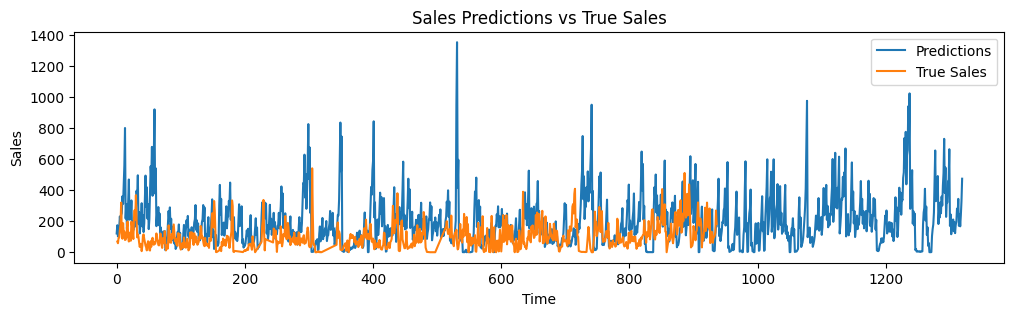

In [143]:
predicitions = df_preds_sarima['PRED'].squeeze().astype(int)
t_sales = raw_sales['SALES'].squeeze().astype(int)


# Plot the data
plt.plot(predicitions, label='Predictions')
plt.plot(t_sales, label='True Sales')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Predictions vs True Sales')

# Add legend
plt.legend()

# Show the plot
plt.show()


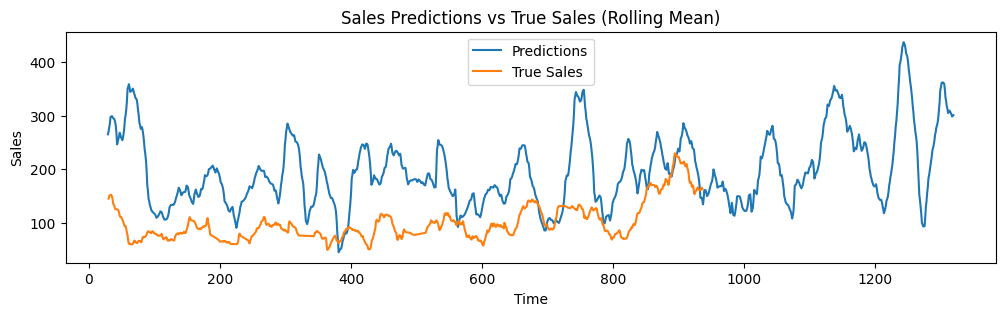

In [144]:
# Calculate the rolling mean with a window size of 7
predictions_rolling = pd.Series(predicitions).rolling(window=30).mean()
true_sales_rolling = pd.Series(t_sales).rolling(window=30).mean()

# Plot the data
plt.plot(predictions_rolling, label='Predictions')
plt.plot(true_sales_rolling, label='True Sales')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Predictions vs True Sales (Rolling Mean)')

# Add legend
plt.legend()

# Show the plot
plt.show()
